# Text Classification. Hash Vectorizer and SVM

We get ~87% classification accuracy on the "ag news" dataset, with a Hashing Vectorizer and an SVM based on gradient descent. No special optimizations were made. The state of the art for this dataset is ~92.5%. See for example
1. R. Johnson, T. Zhang, *Effective Use of Word Order for Text Categorization
with Convolutional Neural Networks*
2. X. Zhan, Y. LeCun, *Text Understanding from Scratch*

In [0]:
!pip uninstall --yes tensorflow
!pip install tensorflow==2.0.0
import tensorflow as tf
print(tf.__version__)

In [0]:
import itertools
import logging
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
import gensim
from gensim.parsing.preprocessing import remove_stopwords
from gensim.parsing.preprocessing import strip_punctuation
from gensim.parsing.preprocessing import strip_short
from gensim.parsing.preprocessing import preprocess_string 
import torch
import torch.nn as nn
import torch.optim as optim

logging.basicConfig(format='%(levelname)s : %(message)s', level=logging.INFO)
logging.root.level = logging.INFO

In [0]:
def doc_cleaner(doc):
    # doc = doc.decode('utf-8')
    doc = doc.lower()        
    doc = re.sub(r':?\\+', ' ', doc)  # remove double backslash
    # doc = re.sub(r'[0-9]+', ' ', doc)  # remove numbers
    # doc = re.sub(r'#[\w-]+', ' ', doc)  # remove hashtag
    # doc = re.sub(r'^[^-]* - ', ' ', doc)  # remove everything before the first hyphen
    doc = re.sub(r'[^A-Z a-z]+', '', doc)
    doc = re.sub(' +', ' ', doc)  # multiple spaces
    return doc

It's useful to have a helper class to stream the batches without having to put in the memory the whole corpus of documents, so I define a generator that iterates over batches of documents. It becomes a necessary step when the corpus does not fit into memory. 

In [0]:
class BatchedCorpus():
    def __init__(self, file_path:str):
        self._file_path = file_path
        
    def get_batch(self, start=0, batch_size=100, preprocess=None):
        """
            Args:
                start (int) = row index where the batch starts
                batch_size (int) = number of samples in the batch
                preprocess (function) = function to preprocess text, i.e., remove special symbols etc.
            Returns:
                tuple (document class (int), document title (str), text (str))
        """
        batch = []
        labels = []
        titles = []
        texts = []
        file = open(self._file_path, 'r') 
        for i, row in enumerate(itertools.islice(file, start, start + batch_size)):
            line = file.readline().split('","')
            labels.append(int(re.sub(r'[^0-9]+', '', line[0])))
            if preprocess:
                texts.append(preprocess(line[2]))
            else:
                texts.append(line[2])
        return labels, texts
    
    def iter_batch(self, batch_size=100, preprocess=None):
      start = 0
      i = 0
      labels, texts = self.get_batch(start, batch_size, preprocess)
      while len(texts):            
          yield labels, texts
          labels, texts = self.get_batch(i * batch_size, batch_size, preprocess)
          i = i + 1

# Main

In [0]:
vectorizer = HashingVectorizer(decode_error='ignore', n_features=2 ** 18,
                                    alternate_sign=False)   
# prepare the test set, it's a small dataset so we just import it
test = pd.read_csv(r'/content/drive/My Drive/test.csv'.replace("\\", "/"), names=["label", "title", "text"])
test.text.apply(doc_cleaner)
X_test = vectorizer.transform(test.text)

[SGD classifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html?highlight=sgdclassifier#sklearn.linear_model.SGDClassifier)  is an sklearn class that implements several different *linear* classifiers and can be used for online (minibatch) training with stochastic gradient descent. As mentioned in the [documentation](https://scikit-learn.org/stable/modules/sgd.html#sgd), *`SGDClassifier` supports multi-class classification by combining multiple binary classifiers in a “one versus all” (OVA) scheme*. We use the support vector and the logistic classifiers

The [Passive Aggressive](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.PassiveAggressiveClassifier.html#sklearn.linear_model.PassiveAggressiveClassifier) classifier is an on-line learning algorithm suited for big data. The sklearn implementation implements a one-versus-rest (or OVA) policy for multiclass classification. After several attempts I changed the regularization parameter `C` to a small value to add regularization.

In [98]:
BATCH_SIZE = 5000
train = BatchedCorpus(r'/content/drive/My Drive/train.csv'.replace("\\", "/"))

ova_SVM = SGDClassifier()
logistic = SGDClassifier(loss="log")
pac = PassiveAggressiveClassifier(C=.01, fit_intercept=True)

classifiers = [ova_SVM, pac, logistic]
clf_names = ['SVM', 'PassiveAggressive', 'Logistic']

train_results = dict([(col, []) for col in clf_names])
test_results = dict([(col, []) for col in clf_names])

for epoch in range(6):
  print("Epoch {}".format(epoch + 1))
  for i, (labels, texts) in enumerate(train.iter_batch(preprocess=doc_cleaner, batch_size=BATCH_SIZE)):
      X = vectorizer.transform(texts)

      # train the classifiers
      for clf, name in zip(classifiers, clf_names):      
          clf.partial_fit(X, labels, np.unique(labels))   
                          
          train_results[name].append(clf.score(X, labels))
          test_results[name].append(clf.score(X_test, test.label.values))    

  for clf, name in zip(classifiers, clf_names): 
    print("{}".format(name))
    print("train accuracy = {:1.6f}, test accuracy = {:1.6f}"
    .format(train_results[name][-1],
            test_results[name][-1]))      

  print(" ")    

Epoch 1
SVM
train accuracy = 0.915600, test accuracy = 0.876053
PassiveAggressive
train accuracy = 0.846000, test accuracy = 0.831579
Logistic
train accuracy = 0.876400, test accuracy = 0.850658
 
Epoch 2
SVM
train accuracy = 0.916400, test accuracy = 0.877895
PassiveAggressive
train accuracy = 0.871600, test accuracy = 0.854868
Logistic
train accuracy = 0.875600, test accuracy = 0.850921
 
Epoch 3
SVM
train accuracy = 0.914800, test accuracy = 0.879737
PassiveAggressive
train accuracy = 0.882400, test accuracy = 0.861974
Logistic
train accuracy = 0.875600, test accuracy = 0.851711
 
Epoch 4
SVM
train accuracy = 0.912000, test accuracy = 0.878421
PassiveAggressive
train accuracy = 0.890000, test accuracy = 0.869079
Logistic
train accuracy = 0.874000, test accuracy = 0.851711
 
Epoch 5
SVM
train accuracy = 0.913200, test accuracy = 0.878026
PassiveAggressive
train accuracy = 0.895600, test accuracy = 0.873026
Logistic
train accuracy = 0.873600, test accuracy = 0.852237
 
Epoch 6
SVM
tra

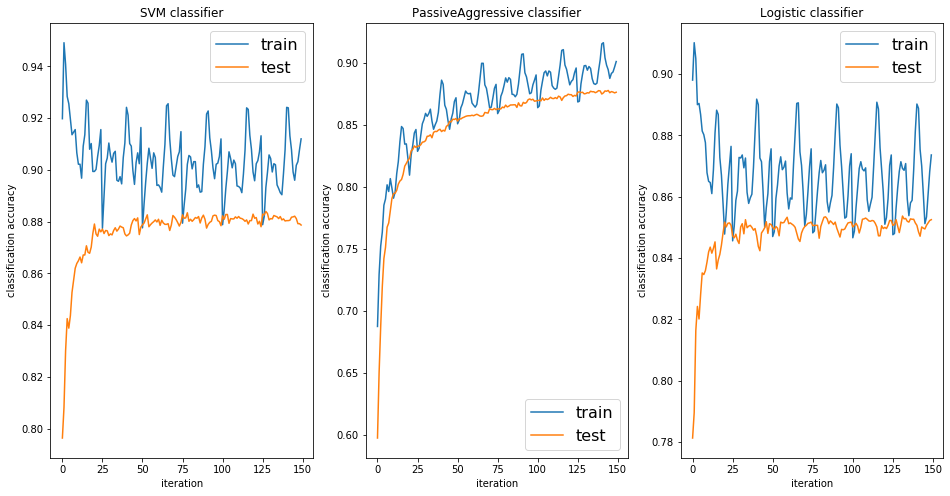

In [99]:
import matplotlib.pyplot as plt
f, ax = plt.subplots(1, 3, figsize=(16, 8))
for i, name in enumerate(clf_names):
  ax[i].plot(train_results[name], label='train')
  ax[i].plot(test_results[name], label='test')
  ax[i].set_title(name + " classifier")
  ax[i].set_ylabel("classification accuracy")
  ax[i].set_xlabel('iteration')
  ax[i].legend(prop={'size': 16})